<a href="https://colab.research.google.com/github/dragonheat123/nll_tryout/blob/master/NLLexample.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

Start by generating synthetic dataset with a heteroscedastic distribution


---

heteroscedasticity (also spelled heteroskedasticity) refers to the circumstance in which the variability of a variable is unequal across the range of values of a second variable that predicts it. (according to google)

---

Plan is to model the product of a sine function and a linear function with additional noise --> predict output with 2 variables:
y = sin(x2)*(A(x1)+b)+noise

For training data, a segment is ommited such that we can test the predictive power of the resulting networks

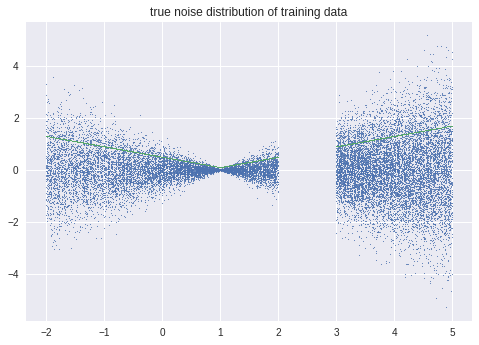

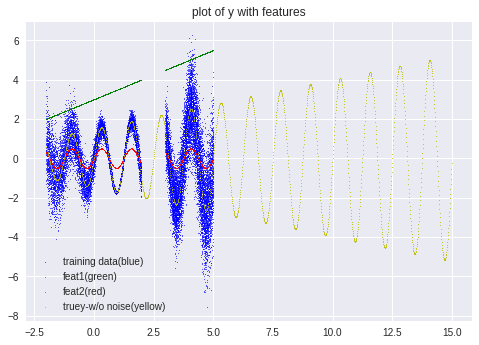

In [0]:
### here we sample x
x1 = np.random.randint(-200,200,10000)/100
x2 = np.random.randint(300,500,10000)/100
x1 = x1.reshape(len(x1),1)
x2 = x2.reshape(len(x2),1)
xrange = np.concatenate((x1,x2),axis=0)
np.shape(xrange)  ##xrange ranges from -2 to 5

###generate random noise
noise_funct = np.random.normal(0,0.4*np.abs(xrange-1)+0.01) #more uncertainty at the edges
plt.figure(1)
plt.scatter(xrange,noise_funct,s=0.5)
plt.scatter(xrange,0.4*np.abs(xrange-1)+0.1,s=0.1)
plt.title('true noise distribution of training data')

### make features from xrange
feat1 = 0.5*xrange+3 #### linear equation
feat2 = 0.5*np.sin(1.6*np.pi*xrange) ###sine wave
feat1 = feat1.reshape(len(feat1),1)
feat2 = feat2.reshape(len(feat2),1)
y = feat1*feat2 + noise_funct
y = y.astype('float32')
realx = np.arange(-2,15,0.01)   ### train from -2 to 5 (break in middle), predict from -2 to 15
realx = realx.reshape(len(realx),1)
realy = (0.5*realx+3)*0.5*np.sin(1.6*np.pi*realx)
realx_c = np.concatenate((0.5*realx+3,0.5*np.sin(1.6*np.pi*realx)),axis=1)
realx_c = realx_c.astype('float32')

plt.figure(2)
plt.scatter(xrange,y,s=0.3,c='b')
plt.scatter(xrange,feat1,s=0.3,c='g')
plt.scatter(xrange,feat2,s=0.3,c='r')
plt.scatter(realx,realy,color='y',s=0.5)
plt.legend(['training data(blue)','feat1(green)','feat2(red)','truey-w/o noise(yellow)'])
plt.title('plot of y with features')

x_input = np.concatenate((feat1,feat2),axis=1)
x_input = x_input.astype('float32')
np.shape(x_input)

xmin = np.array([-2,-1])
xmax = np.array([10,1])
ymin = np.array([-15])
ymax = np.array([15])

x_train = ((x_input-xmin)/(xmax-xmin))
y_train = ((y-ymin)/(ymax-ymin))

x_test = ((realx_c-xmin)/(xmax-xmin))
y_test = ((realy-ymin)/(ymax-ymin))

yreal_n = []
for i in range(0,200):
  yreal_n.append((0.5*realx+3)*0.5*np.sin(1.6*np.pi*realx)+np.random.normal(0,0.4*np.abs(realx-1)+0.01))
  
yreal_std = np.std(y)

To find the optimal values for the parameters, we maximise the log likelihood function of the model.  
We assume that the output error is generated by a gaussian distribution:


---


$$log P(y|x,\theta) = log\Pi{P(y^i|x^i;\theta)}$$

---


$$= \sum logP(y^i|x^i;\theta)$$

---


$$=\sum log(\frac{1}{\sqrt{2\pi\sigma_{x^i}^2}} exp(-\frac{(y^i-f_\theta({x^i}))^2}{2\sigma_{x^i}^2}))$$

---


$$= \sum log(1) - \frac{1}{2}log(2\pi) - \frac{1}{2}log(\sigma_{x^i}^2) - \frac{(y^i-f_\theta({x^i}))^2}{2\sigma_{x^i}^2}$$


This is equivalant to minimizing the following function termed as negative log likelihood, the constant terms is ignored cause it will not participate in gradient descent:
$$ (\sigma_{x^i})^2 = var(f_\theta({x^i}))$$
$$\sum -(-\frac{1}{2}log(\sigma_{x^i}^2) - \frac{(y^i-f_\theta({x^i}))^2}{2\sigma_{x^i}^2}) = $$
$$\sum (\frac{1}{2}log(\sigma_{x^i}^2) + \frac{(y^i-f_\theta({x^i}))^2}{2\sigma_{x^i}^2})$$

For this problem, a monte carlo dropout neural network is used. Addition of the dropout layers inbetween fully connected layers allows the approximation of a normal neural network to a bayesian statistical network (Gal 2015) that help to quantify model uncertainty. This paper suggested a  MSE loss function for model training, modelling the output error as a normal distribution with variance of 1. However, this might not be the case, causing mostly underestimation of uncertainty.  
To overcome this problem, (Lakshminarayanan 2016) suggests using a proper scoring function like the negative log likehood, which allows the model to take into account heteroscedastic error in output.

Using TensorFlow backend.


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 2)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1536      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 128)               32896     
_________________________________________________________________
dropout_3 (Dropout)          (None, 128)               0         
__________

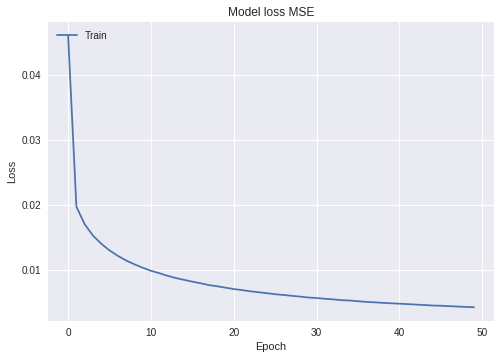

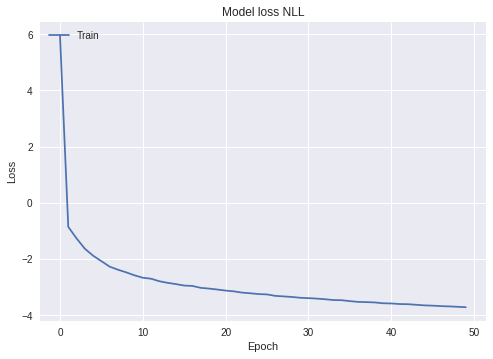

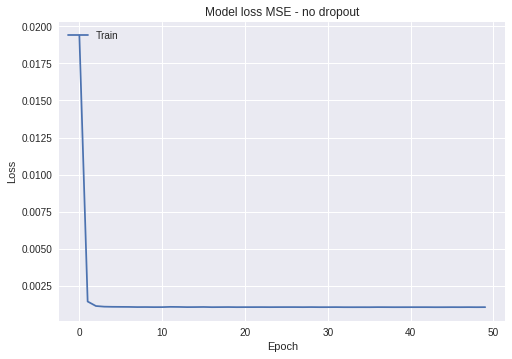

In [0]:
###def NLL and MSE loss and resulting model

import keras
from keras import backend as K
K.clear_session()

input_layer = keras.Input(shape=(2,))
#do_1 = keras.layers.Dropout(0.5)(input_layer, training=True)
dense1 = keras.layers.Dense(512,activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(input_layer)
do_2 = keras.layers.Dropout(0.1)(dense1, training=True)
dense2 = keras.layers.Dense(256,activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(do_2)
do_3 = keras.layers.Dropout(0.1)(dense2, training=True)
dense3 = keras.layers.Dense(128,activation='relu', kernel_regularizer=keras.regularizers.l2(0.0001))(do_3)
do_4 = keras.layers.Dropout(0.1)(dense3, training=True)
output_layer = keras.layers.Dense(1)(do_4)
model = keras.Model(inputs=input_layer, outputs=output_layer)
model.compile(loss='mse',optimizer='adagrad')
model.summary()

def custom_loss(y_true, y_pred):
  var = K.var(y_pred)
  return K.mean( K.square(y_pred - y_true)/var + K.log(var), axis=-1)

ainput_layer = keras.Input(shape=(2,))
#do_1 = keras.layers.Dropout(0.5)(input_layer, training=True)
adense1 = keras.layers.Dense(512,activation='relu',kernel_regularizer=keras.regularizers.l2(0.01))(ainput_layer)
ado_2 = keras.layers.Dropout(0.1)(adense1, training=True)
adense2 = keras.layers.Dense(256,activation='relu',kernel_regularizer=keras.regularizers.l2(0.01))(ado_2)
ado_3 = keras.layers.Dropout(0.1)(adense2, training=True)
adense3 = keras.layers.Dense(128,activation='relu',kernel_regularizer=keras.regularizers.l2(0.01))(ado_3)
ado_4 = keras.layers.Dropout(0.1)(adense3, training=True)
aoutput_layer = keras.layers.Dense(1)(ado_4)
model2 = keras.Model(inputs=ainput_layer, outputs=aoutput_layer)
model2.compile(loss=custom_loss,optimizer='adagrad')
model2.summary()

binput_layer = keras.Input(shape=(2,))
bdense1 = keras.layers.Dense(512,activation='relu')(binput_layer)
bdense2 = keras.layers.Dense(256,activation='relu')(bdense1)
bdense3 = keras.layers.Dense(128,activation='relu')(bdense2)
boutput_layer = keras.layers.Dense(1)(bdense3)
model3 = keras.Model(inputs=binput_layer, outputs=boutput_layer)
model3.compile(loss="mse",optimizer='adagrad')
model3.summary()


history = model.fit(x_train, y_train, shuffle=True, epochs=50, verbose=0, batch_size=256)
history2 = model2.fit(x_train, y_train, shuffle=True, epochs=50, verbose=0, batch_size=256)
history3 = model3.fit(x_train, y_train, shuffle=True, epochs=50, verbose=0, batch_size=256)

plt.figure(3)
plt.plot(history.history['loss'])
plt.title('Model loss MSE')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

plt.figure(4)
plt.plot(history2.history['loss'])
plt.title('Model loss NLL')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()


plt.figure(10)
plt.plot(history3.history['loss'])
plt.title('Model loss MSE - no dropout')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



In [0]:
###inference
mat = []
mat2 = []
for i in range(0,200):
    mat.append(model.predict(x_test))
    mat2.append(model2.predict(x_test))
    #print(i)

a = np.mean(mat,axis=0)
b = np.std(mat,axis=0)
a2 = np.mean(mat2,axis=0)
b2 = np.std(mat2,axis=0)

a3 = model3.predict(x_test)


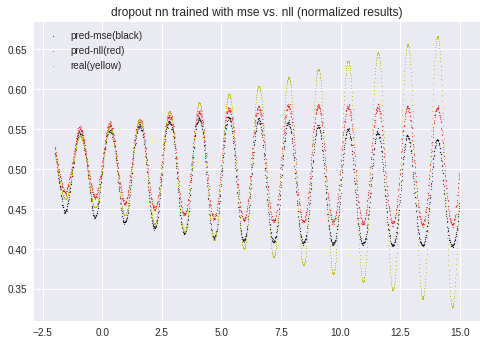

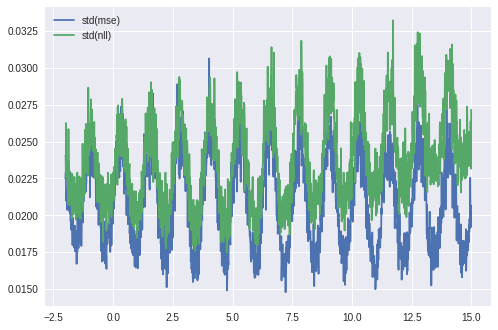

In [0]:
plt.figure(5)  
plt.scatter(realx,a,alpha=0.5,s=1,c='k')
plt.scatter(realx,a2,alpha=0.5,s=1,c='r')
plt.scatter(realx,y_test,color='y',s=0.5)
plt.legend(['pred-mse(black)','pred-nll(red)','real(yellow)'])    
plt.title('dropout nn trained with mse vs. nll (normalized results)')

plt.figure(15)
plt.plot(realx,b)
plt.plot(realx,b2)
plt.legend(['std(mse)','std(nll)'])


mape_mse:  5.208520302833368 %
mape_nll:  5.862871683653642 %
mape_mse_ndo 5.322981433005823 %


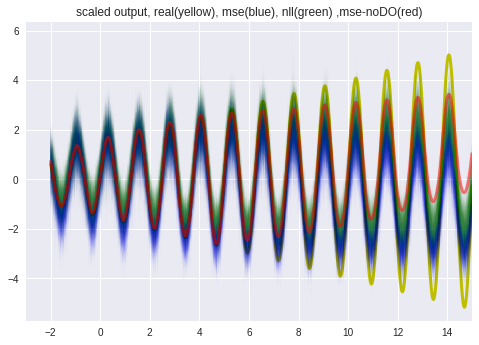

In [0]:
plt.figure(6)  
plt.plot(realx,y_test*(ymax-ymin)+ymin,color='y',linewidth=3)
for i in range(0,100):
  plt.plot(realx,mat[i]*(ymax-ymin)+ymin,color='b',alpha=0.05,linewidth=0.1)
  plt.plot(realx,mat2[i]*(ymax-ymin)+ymin,color='g',alpha=0.05,linewidth=0.1)
plt.plot(realx,a3*(ymax-ymin)+ymin,color='r',alpha=0.5,linewidth=3)
plt.title("scaled output, real(yellow), mse(blue), nll(green) ,mse-noDO(red)")
plt.xlim([-3,15])

mape_mse = np.mean(np.abs((y_test - a.reshape(len(a),1))/ y_test)) 
mape_nll = np.mean(np.abs((y_test - a2.reshape(len(a2),1))/ y_test))
mape_mse_ndo = np.mean(np.abs((y_test - a3.reshape(len(a3),1))/ y_test))

print("mape_mse: ",mape_mse*100,"%")
print("mape_nll: ",mape_nll*100,"%")
print("mape_mse_ndo",mape_mse_ndo*100,"%")


## seems like the model is not able to capture the true uncertainty distribution but is able to interpolate and predict quite well??
## even the parts (2-3) with no data, it is predicting with high certainty???
## Training by NLL at least force the model to acknowledge the lack of data at when predicting >7

Since the dropout layers are unable to totally capture the true uncertainty of the data, (Nix 1994, Yao 2017) suggest the addition of a softplus activation unit (to predict output variance) on top of a linear unit (to predict the mean), while training the model using NLL. The difference between Nix and Yao is that Nix has separate layers connected to the variance output unit whereas Yao has shared layers between the mean output and variance output unit.  

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            (None, 2)            0                                            
__________________________________________________________________________________________________
dense_13 (Dense)                (None, 512)          1536        input_4[0][0]                    
__________________________________________________________________________________________________
dropout_7 (Dropout)             (None, 512)          0           dense_13[0][0]                   
__________________________________________________________________________________________________
dense_14 (Dense)                (None, 256)          131328      dropout_7[0][0]                  
__________________________________________________________________________________________________
dropout_8 

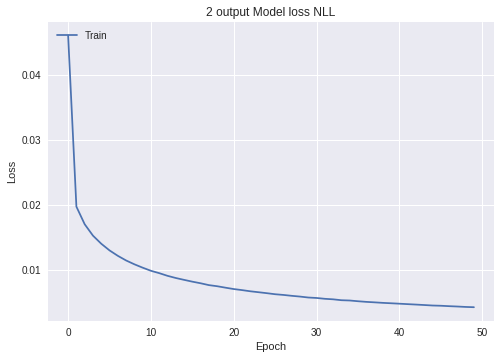

In [0]:
def custom_loss_2(doutput_layer,doutput_var):
  def nll_loss(y_true, y_pred):
    loss = K.mean( K.square(doutput_layer - y_true)/doutput_var + K.log(doutput_var), axis=-1)+K.mean(K.square(doutput_layer - y_true), axis=-1)
    return loss
  return nll_loss
def custom_loss_3(doutput_layer):
  def meanse(y_true, y_pred):
    loss = K.mean(K.square(doutput_layer - y_true), axis=-1)
    return loss
  return meanse

dinput_layer = keras.Input(shape=(2,))
#do_1 = keras.layers.Dropout(0.5)(input_layer, training=True)
ddense1 = keras.layers.Dense(512,activation='relu')(dinput_layer)
ddo_2 = keras.layers.Dropout(0.1)(ddense1)
ddense2 = keras.layers.Dense(256,activation='relu')(ddo_2)
ddo_3 = keras.layers.Dropout(0.1)(ddense2)
ddense3 = keras.layers.Dense(128,activation='relu')(ddo_3)
ddo_4 = keras.layers.Dropout(0.1)(ddense3)
doutput_layer = keras.layers.Dense(1)(ddo_4)
doutput_var = keras.layers.Dense(1,activation='softplus')(ddo_4)       ###softplus function to estimate variance
model4 = keras.Model(inputs=dinput_layer, outputs=[doutput_layer,doutput_var])
model4.compile(loss=[custom_loss_2(doutput_layer, doutput_var),custom_loss_2(doutput_layer, doutput_var)],optimizer='adagrad')
model4.summary()

history4 = model4.fit(x_train, [y_train,y_train] , shuffle=True, epochs=50, verbose=0, batch_size=256)

plt.figure(13)
plt.plot(history.history['loss'])
plt.title('2 output Model loss NLL')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()



(2, 1700, 1)
[[0.67511661]
 [0.68697715]
 [0.68793253]
 ...
 [0.58515322]
 [0.57576374]
 [0.6189357 ]]


(0, 1.3)

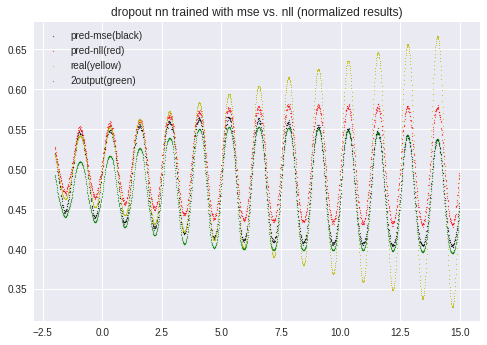

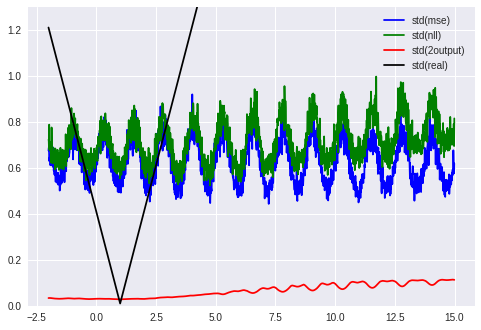

In [0]:
d = model4.predict(x_test)
print(np.shape(d))

dmean = d[0]
dvar = d[1]

plt.figure(15)  
plt.scatter(realx,a,alpha=0.5,s=1,c='k')
plt.scatter(realx,a2,alpha=0.5,s=1,c='r')
plt.scatter(realx,y_test,color='y',s=0.5)
plt.scatter(realx,dmean,alpha=0.5,s=1,c='g')
plt.legend(['pred-mse(black)','pred-nll(red)','real(yellow)','2output(green)'])    
plt.title('dropout nn trained with mse vs. nll (normalized results)')

amat = [(x+ymin)*(ymax-ymin) for x in mat]
amat2 = [(x+ymin)*(ymax-ymin) for x in mat2]


ab = np.std(amat,axis=0)
ab2 = np.std(amat2,axis=0)

print(ab)

plt.figure(17)
plt.plot(realx,ab,'b')
plt.plot(realx,ab2,'g')
plt.plot(realx,np.sqrt(dvar),'r')
plt.plot(realx,0.4*np.abs(realx-1)+0.01,'k')
plt.legend(['std(mse)','std(nll)','std(2output)','std(real)'])
plt.ylim([0,1.3])



In [0]:
mape_2output = np.mean(np.abs((y_test - dmean.reshape(len(dmean),1))/ y_test))

print("mape_mse: ",mape_mse*100,"%")
print("mape_nll: ",mape_nll*100,"%")
print("mape_mse_ndo: ",mape_mse_ndo*100,"%")
print("mape_2output: ",mape_2output*100,"%")

mape_mse:  5.208520302833368 %
mape_nll:  5.862871683653642 %
mape_mse_ndo:  5.322981433005823 %
mape_2output:  6.844977467535389 %


All models are underestimating the real model noise. Perhaps the test data has too high a signal to noise ratio, 
Seems like Dropout NN with NLL is the best bet for uncertainty estimation. 
Dropout NN with MSE give the best performance but then to underestimate error

References:


---

https://fairyonice.github.io/Create-a-neural-net-with-a-negative-log-likelihood-as-a-loss.html

---

(Lakshminarayanan 2016) https://papers.nips.cc/paper/7219-simple-and-scalable-predictive-uncertainty-estimation-using-deep-ensembles.pdf

---
(Gal 2015) Dropout as bayesian approximation: 
https://arxiv.org/abs/1506.02142

---

(Yao 2017) Rdeepsense:
https://arxiv.org/abs/1709.02980 

---

(Nix 1994) Estimating the mean and variance of the target probability distribution: https://ieeexplore.ieee.org/document/374138

